# Alternative classification using Persistence Landscapes

For comparison, here we use instead a vectorisation technique, by converting the SDPH diagrams into landscapes, and training common classifiers to determine the their performance in distinguishing between samples from the different Phases.


In [1]:
import persim 
persim.__version__

'0.3.5'

In [2]:
# load data
import numpy as np
import pickle
import math
import time
import sys
module_paths = ['']
for path in module_paths :
    if path not in sys.path:
        sys.path.append(path)

from utils_load_PHloc import (extract_PH_heatmaps_single_sample,
extract_heatmap_grid,
contour_heatmaps,
collect_paired_crit_sizes,
collect_indiv_crit_sizes)

from utils_load_PHloc import datasets_of_interest, injected_datasets_of_interest, levels_of_interest

# folder where you put the PHloc files
PH_folder = '' 

# choose desired anatomy: 'knee', 'long', 'both' (which is a merge of the birth-death points)
anatomy = 'knee'

# load file
filepath = PH_folder + 'PH_all_{}.pkl'.format(anatomy)
print('I will load',filepath)
PH_all_datasets = pickle.load(open(filepath, 'rb'))

# threshold value
THR = .5

# generate a new dictionary for truncated datasets
truncated_PH_all_datasets = {}
for i in datasets_of_interest:
    diagram = PH_all_datasets[i]
    truncated_PH_all_datasets[i] = diagram[diagram[:,1] >= diagram[:,0] + THR]
    
# print size of the diagrams
for i in datasets_of_interest:
    diagram1 = PH_all_datasets[i]
    diagram2 = truncated_PH_all_datasets[i]
print("done")

names = [injected_datasets_of_interest[i]+"_"+[str(x) for x in datasets_of_interest][i] for i in range(27)]

labels = ['CTRL_0%(1)', 'CTRL_0%(2)', 'CTRL_0%(3)', 'CTRL_0%(4)', 
          'U937_1%(1)', 'U937_1%(2)', 'U937_7%', 'U937_8%', 'U937_10%(1)', 'U937_10%(2)', 'U937_10%(3)', 
          'HL60_23%', 'HL60_25%(1)', 'HL60_25%(2)', 
          'P1_10%', 'P1_40%', 'P1_44%', 'P1_51%', 'P1_60%', 'P1_76%', 
          'P2_59%', 'P2_88%', 'P2_90%', 
          'MNC_53%', 'MNC_67%', 'MNC_75%', 'MNC_86%']

phases_of_interest = [0,0,0,0,
         1,1,1,1,1,1,1,
         1,1,1,
         1,2,2,2,2,1,
         2,2,2,
         1,2,2,2]

name_phase = [labels[i]+" [Phase "+str(phases_of_interest[i])+"]" for i in range(27)]

import matplotlib.pyplot as plt

################ PARAMETERS

# default values used: WEIGHTS = True (dirac masses weighted by persistence) ; SIGMA = .5

WEIGHTS = True
SIGMA = .5

# Binning parameters
XLIMS = np.array([[-15,0],[-10,10],[0,20]])
YLIMS = np.array([[-8,7],[-5,15],[0,20]])
NB_BINS_PER_SIDE = 100

groups_of_interest = [0,0,0,0,
                          1,1,2,2,2,1,2,
                          1,1,2,
                          1,1,3,3,3,1,
                          3,3,3,
                          1,3,3,3]

name_group = [labels[i]+" [Group "+str(groups_of_interest[i])+"]" for i in range(27)]

import sklearn

import torch

# pds contains all diagrams
pds = [truncated_PH_all_datasets[i] for i in datasets_of_interest]



I will load PH_all_knee.pkl
done


In [3]:
# for persim need to convert the data into the form of list of arrays, one for each dimension
pds_list = []
for j in range(27):
    current_pd = pds[j]
    pds_list.append([current_pd[current_pd[:,2]==i,:2] for i in range(3)])

# Transform PDs into landscapes

In [4]:
from persim.landscapes import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from persim.landscapes import PersistenceLandscaper
from persim import plot_diagrams

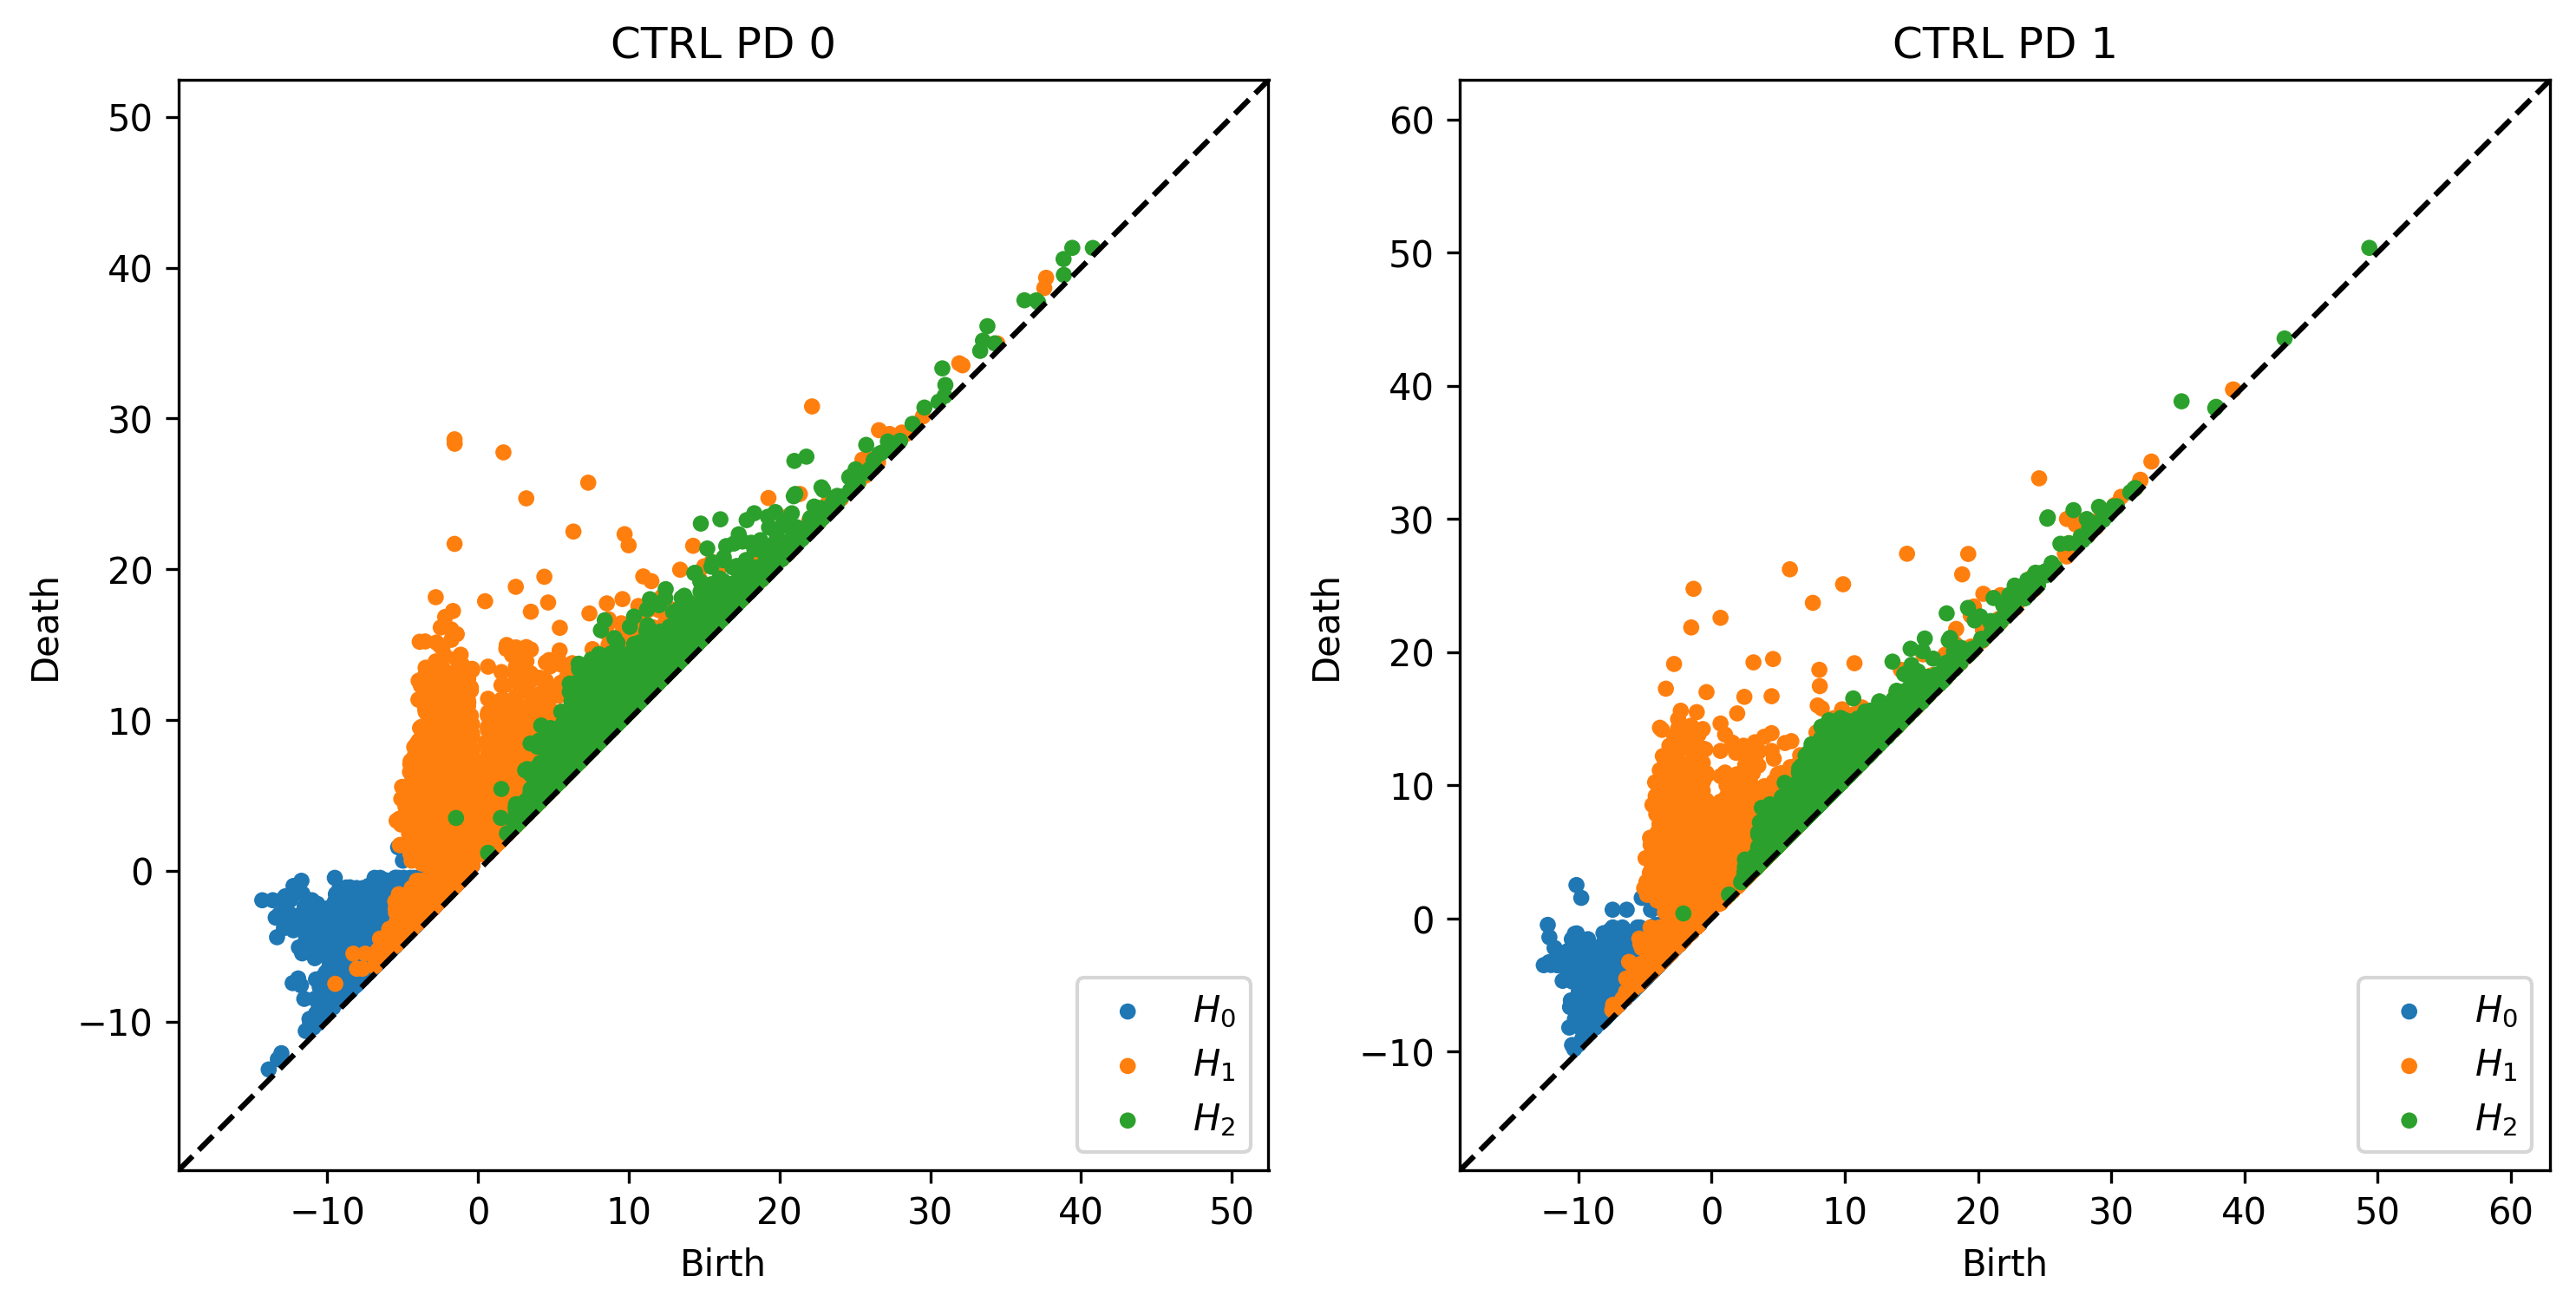

In [6]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)
# plot ctrl pds as example
plot_diagrams(pds_list[0], title="CTRL PD 0", ax=axs[0])
plot_diagrams(pds_list[1], title="CTRL PD 1", ax=axs[1])

fig.tight_layout()

In [7]:
# using PersistenceLandscaper generate landscapes of the same resolution

pl_0 = PersistenceLandscaper(hom_deg=0, start = -15, stop = 0,  num_steps=100, flatten=True)
pl_1 = PersistenceLandscaper(hom_deg=1, start = -10, stop = 10,  num_steps=100, flatten=True)
pl_2 = PersistenceLandscaper(hom_deg=2, start = 0, stop = 20,  num_steps=100, flatten=True)

# Convert the SDPH diagrams into Persistence Landscapes

In [7]:
ph0_pl = []
ph1_pl = []
ph2_pl = []

for i in range(27):
    current = pds_list[i]
    ph0_pl.append(pl_0.fit_transform(current))
    ph1_pl.append(pl_1.fit_transform(current))
    ph2_pl.append(pl_2.fit_transform(current))

    

In [9]:
print([len(x) for x in ph0_pl]) # check length 

[595800, 417300, 572800, 467400, 266300, 344800, 593700, 384200, 529900, 379600, 457900, 439000, 359500, 363600, 459800, 359100, 400600, 303600, 329100, 244900, 358200, 237600, 196000, 397600, 294300, 312300, 348800]


In [20]:
# take first 100 landscapes
ph0_pl100 = [x[:10000] for x in ph0_pl]
ph1_pl100 = [x[:10000] for x in ph1_pl]
ph2_pl100 = [x[:10000] for x in ph2_pl]

# Construct trees from PLs

In [13]:
# Importing necessary libraries from BioPython
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor


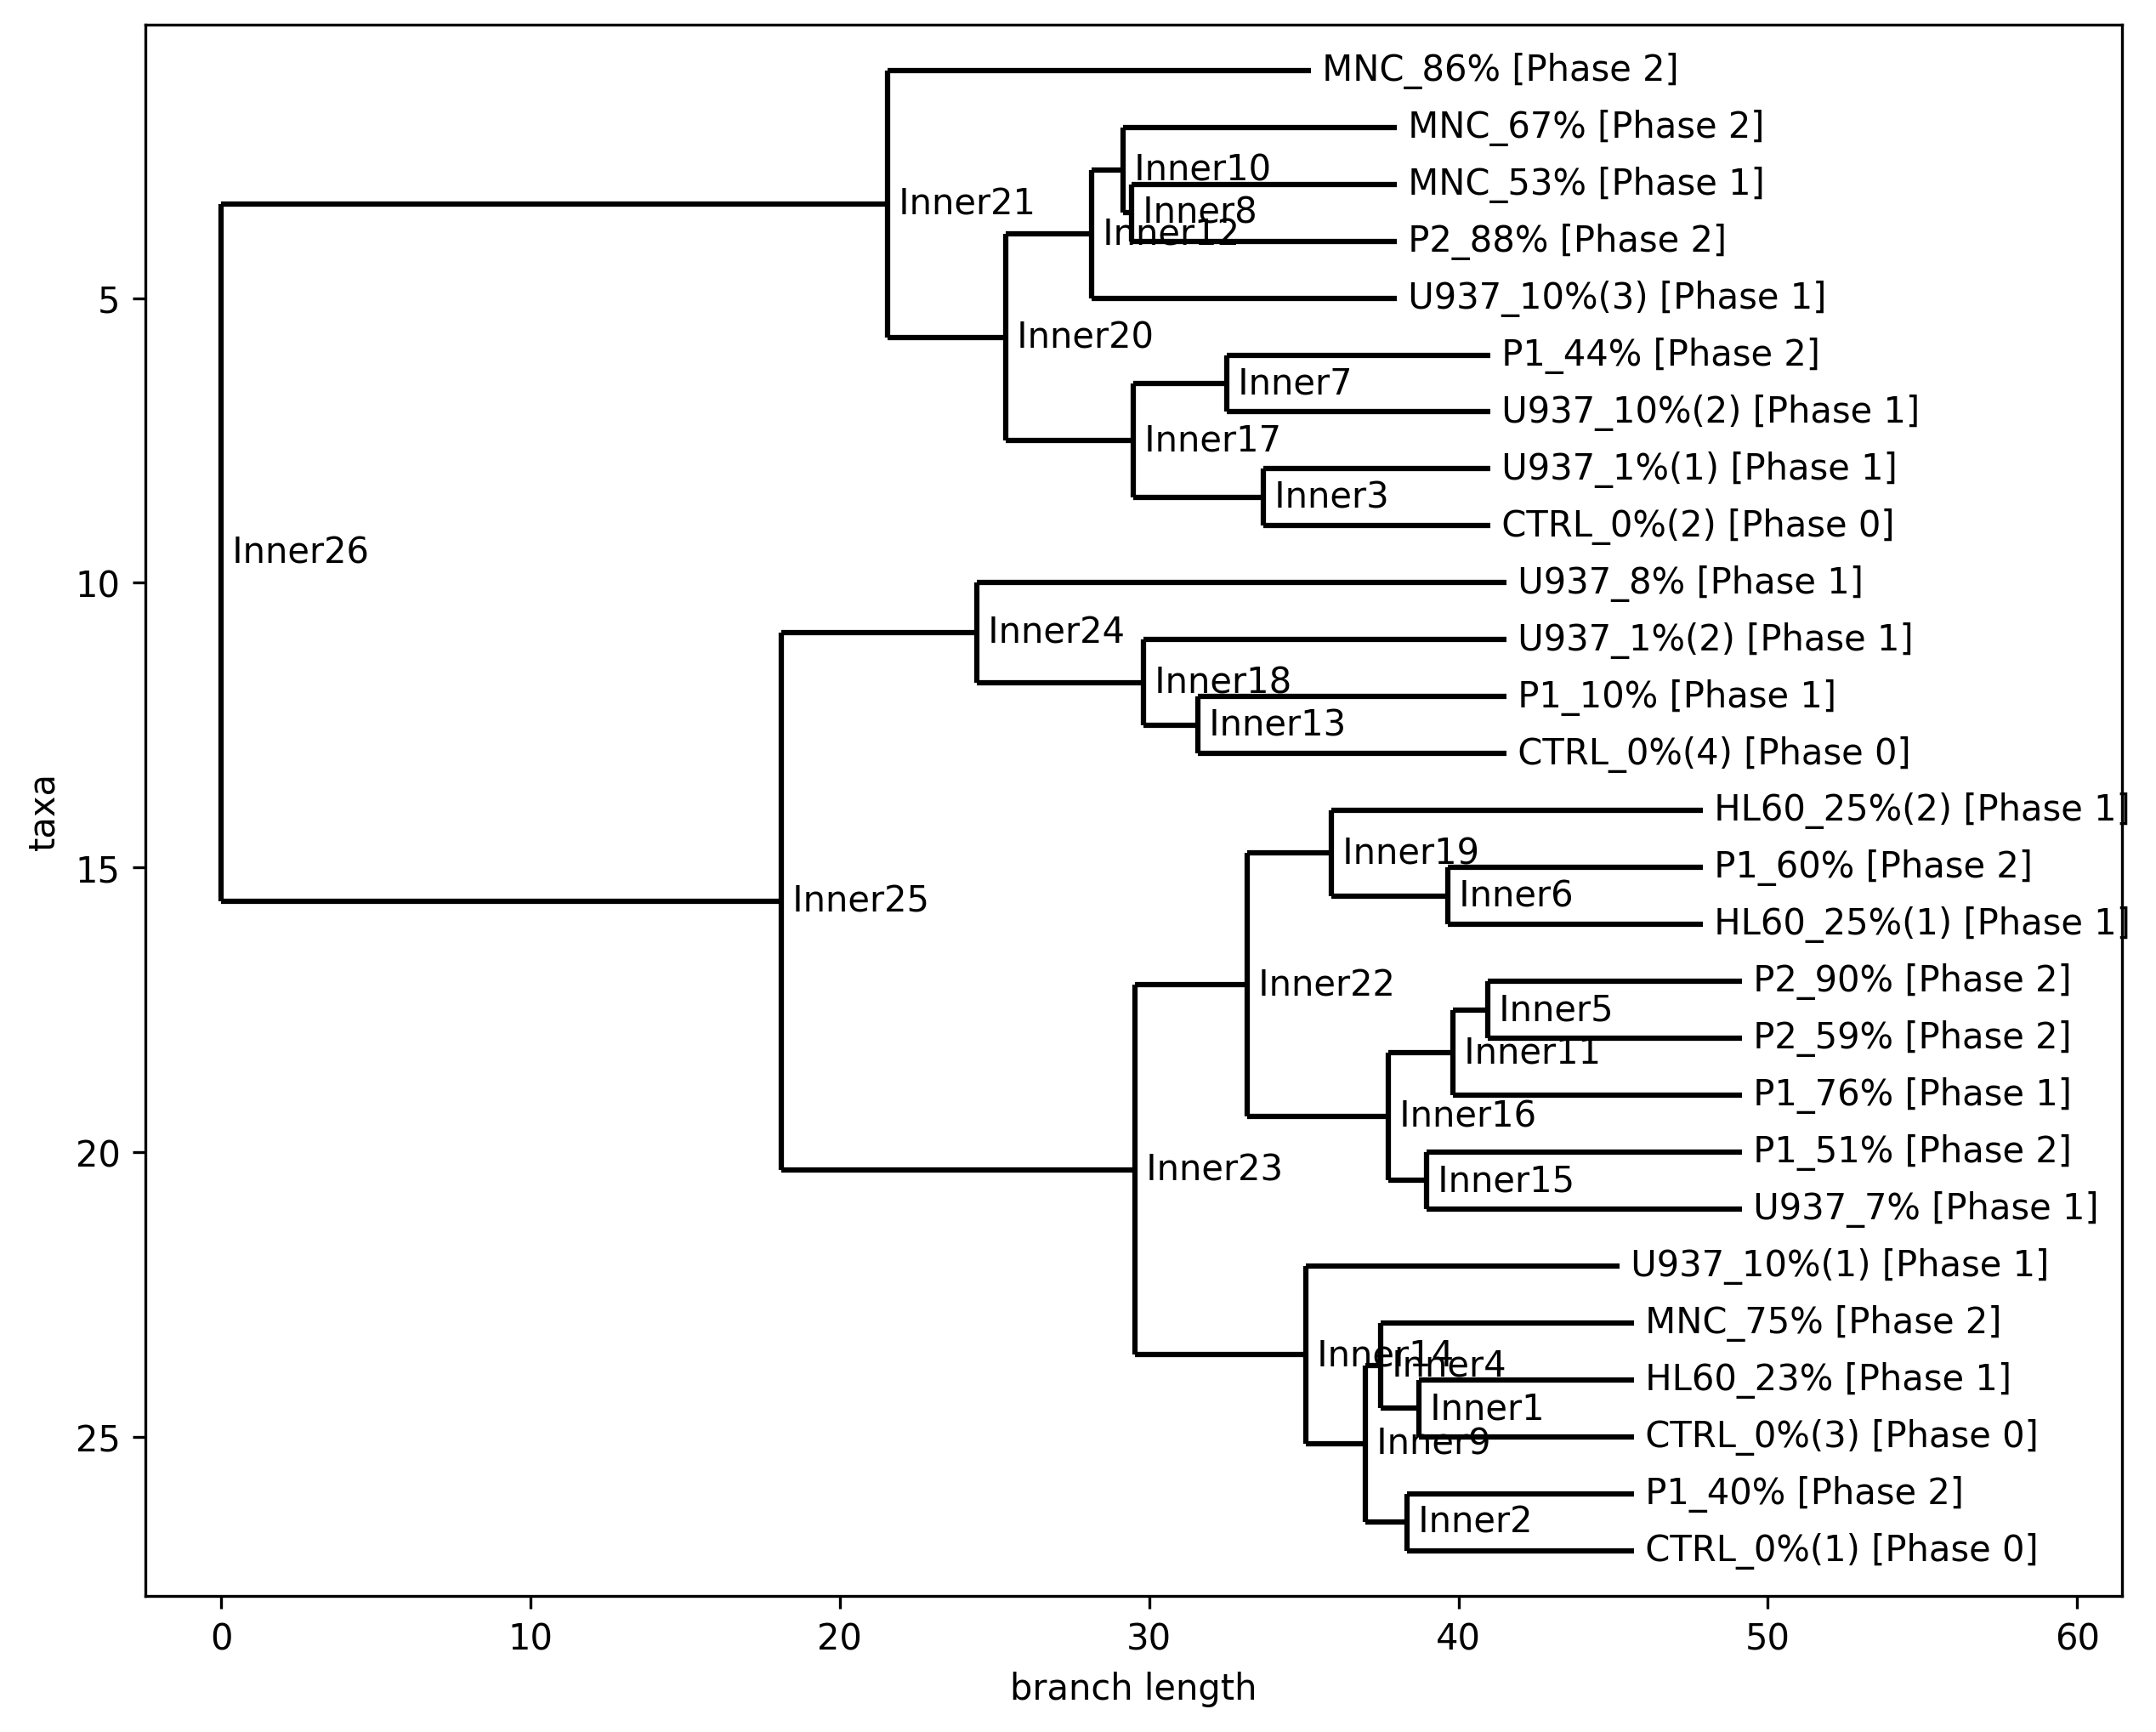

In [17]:
ph0_dist = []
for i in range(27):
    ls = []
    for j in range(i+1):
        ls.append(np.linalg.norm(ph0_pl100[i]-ph0_pl100[j]))
    ph0_dist.append(ls)
    
constructor = DistanceTreeConstructor()
ph0_distmat = Phylo.TreeConstruction._DistanceMatrix(name_phase, ph0_dist)
UPGMATree = constructor.upgma(ph0_distmat)
fig = plt.figure(figsize=(10,8), dpi=300)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(UPGMATree, axes=axes)

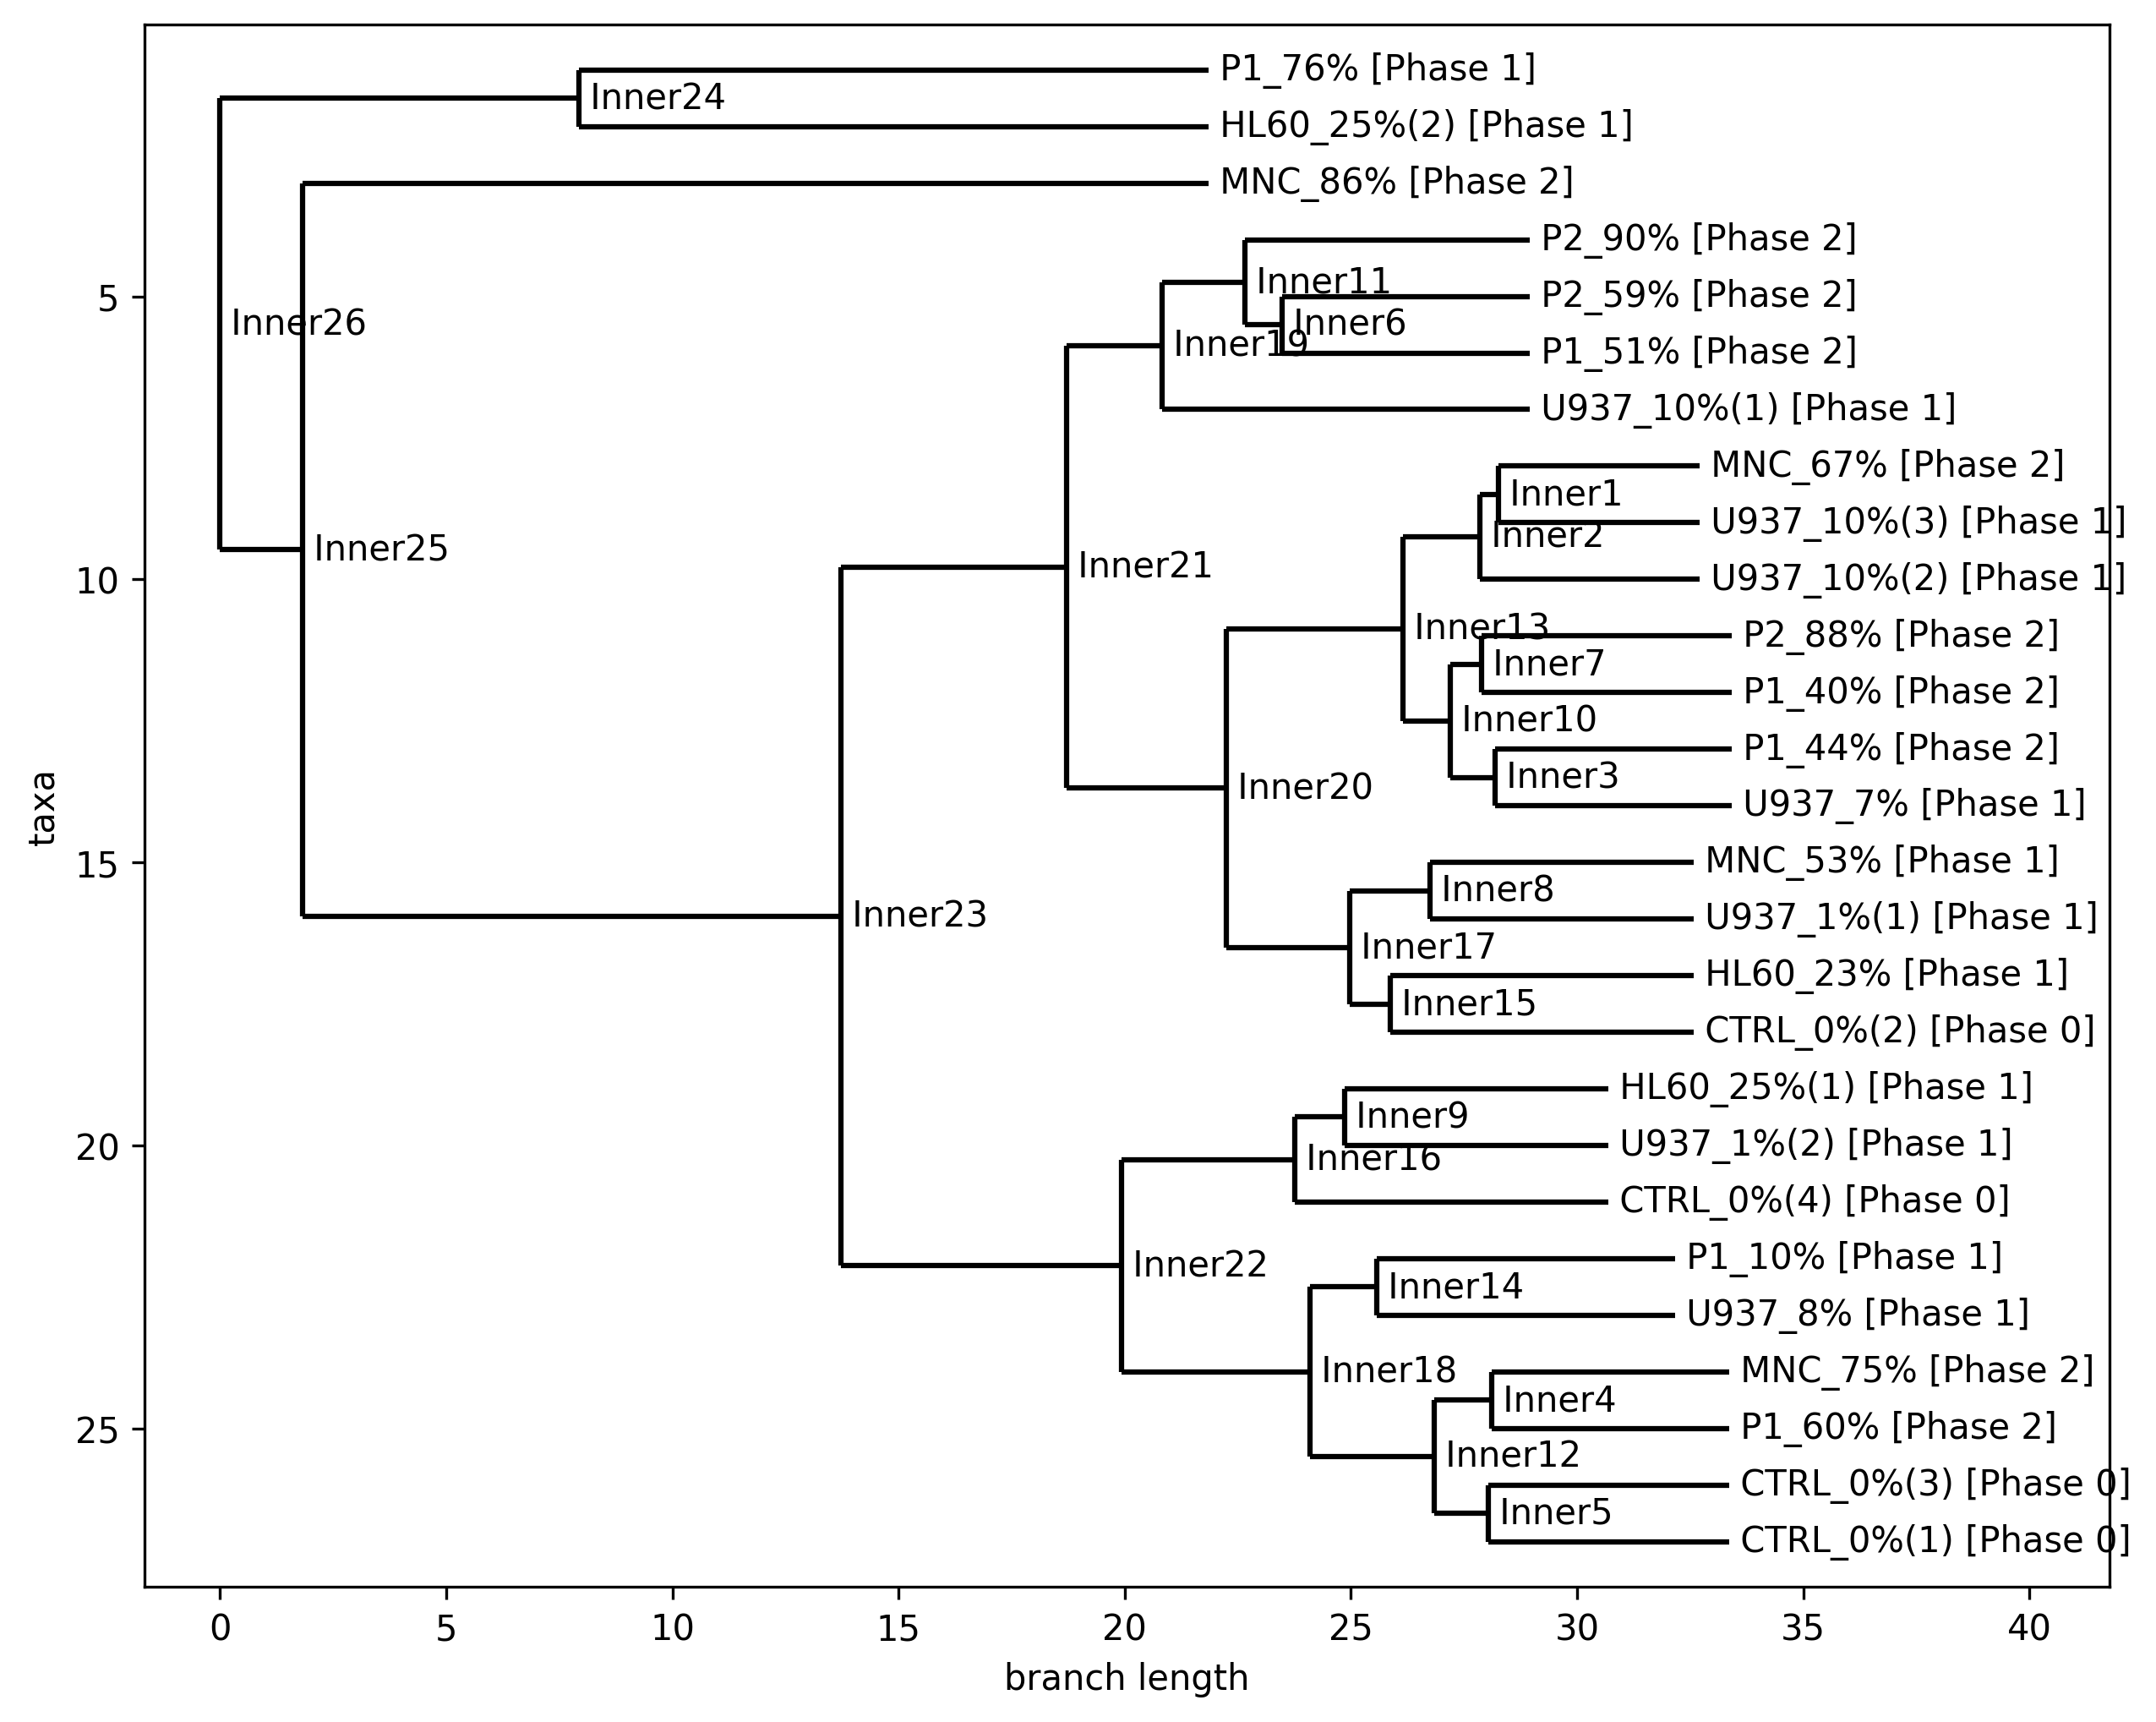

In [21]:
ph1_dist = []
for i in range(27):
    ls = []
    for j in range(i+1):
        ls.append(np.linalg.norm(ph1_pl100[i]-ph1_pl100[j]))
    ph1_dist.append(ls)
    
constructor = DistanceTreeConstructor()
ph1_distmat = Phylo.TreeConstruction._DistanceMatrix(name_phase, ph1_dist)
UPGMATree = constructor.upgma(ph1_distmat)
fig = plt.figure(figsize=(10,8), dpi=300)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(UPGMATree, axes=axes)

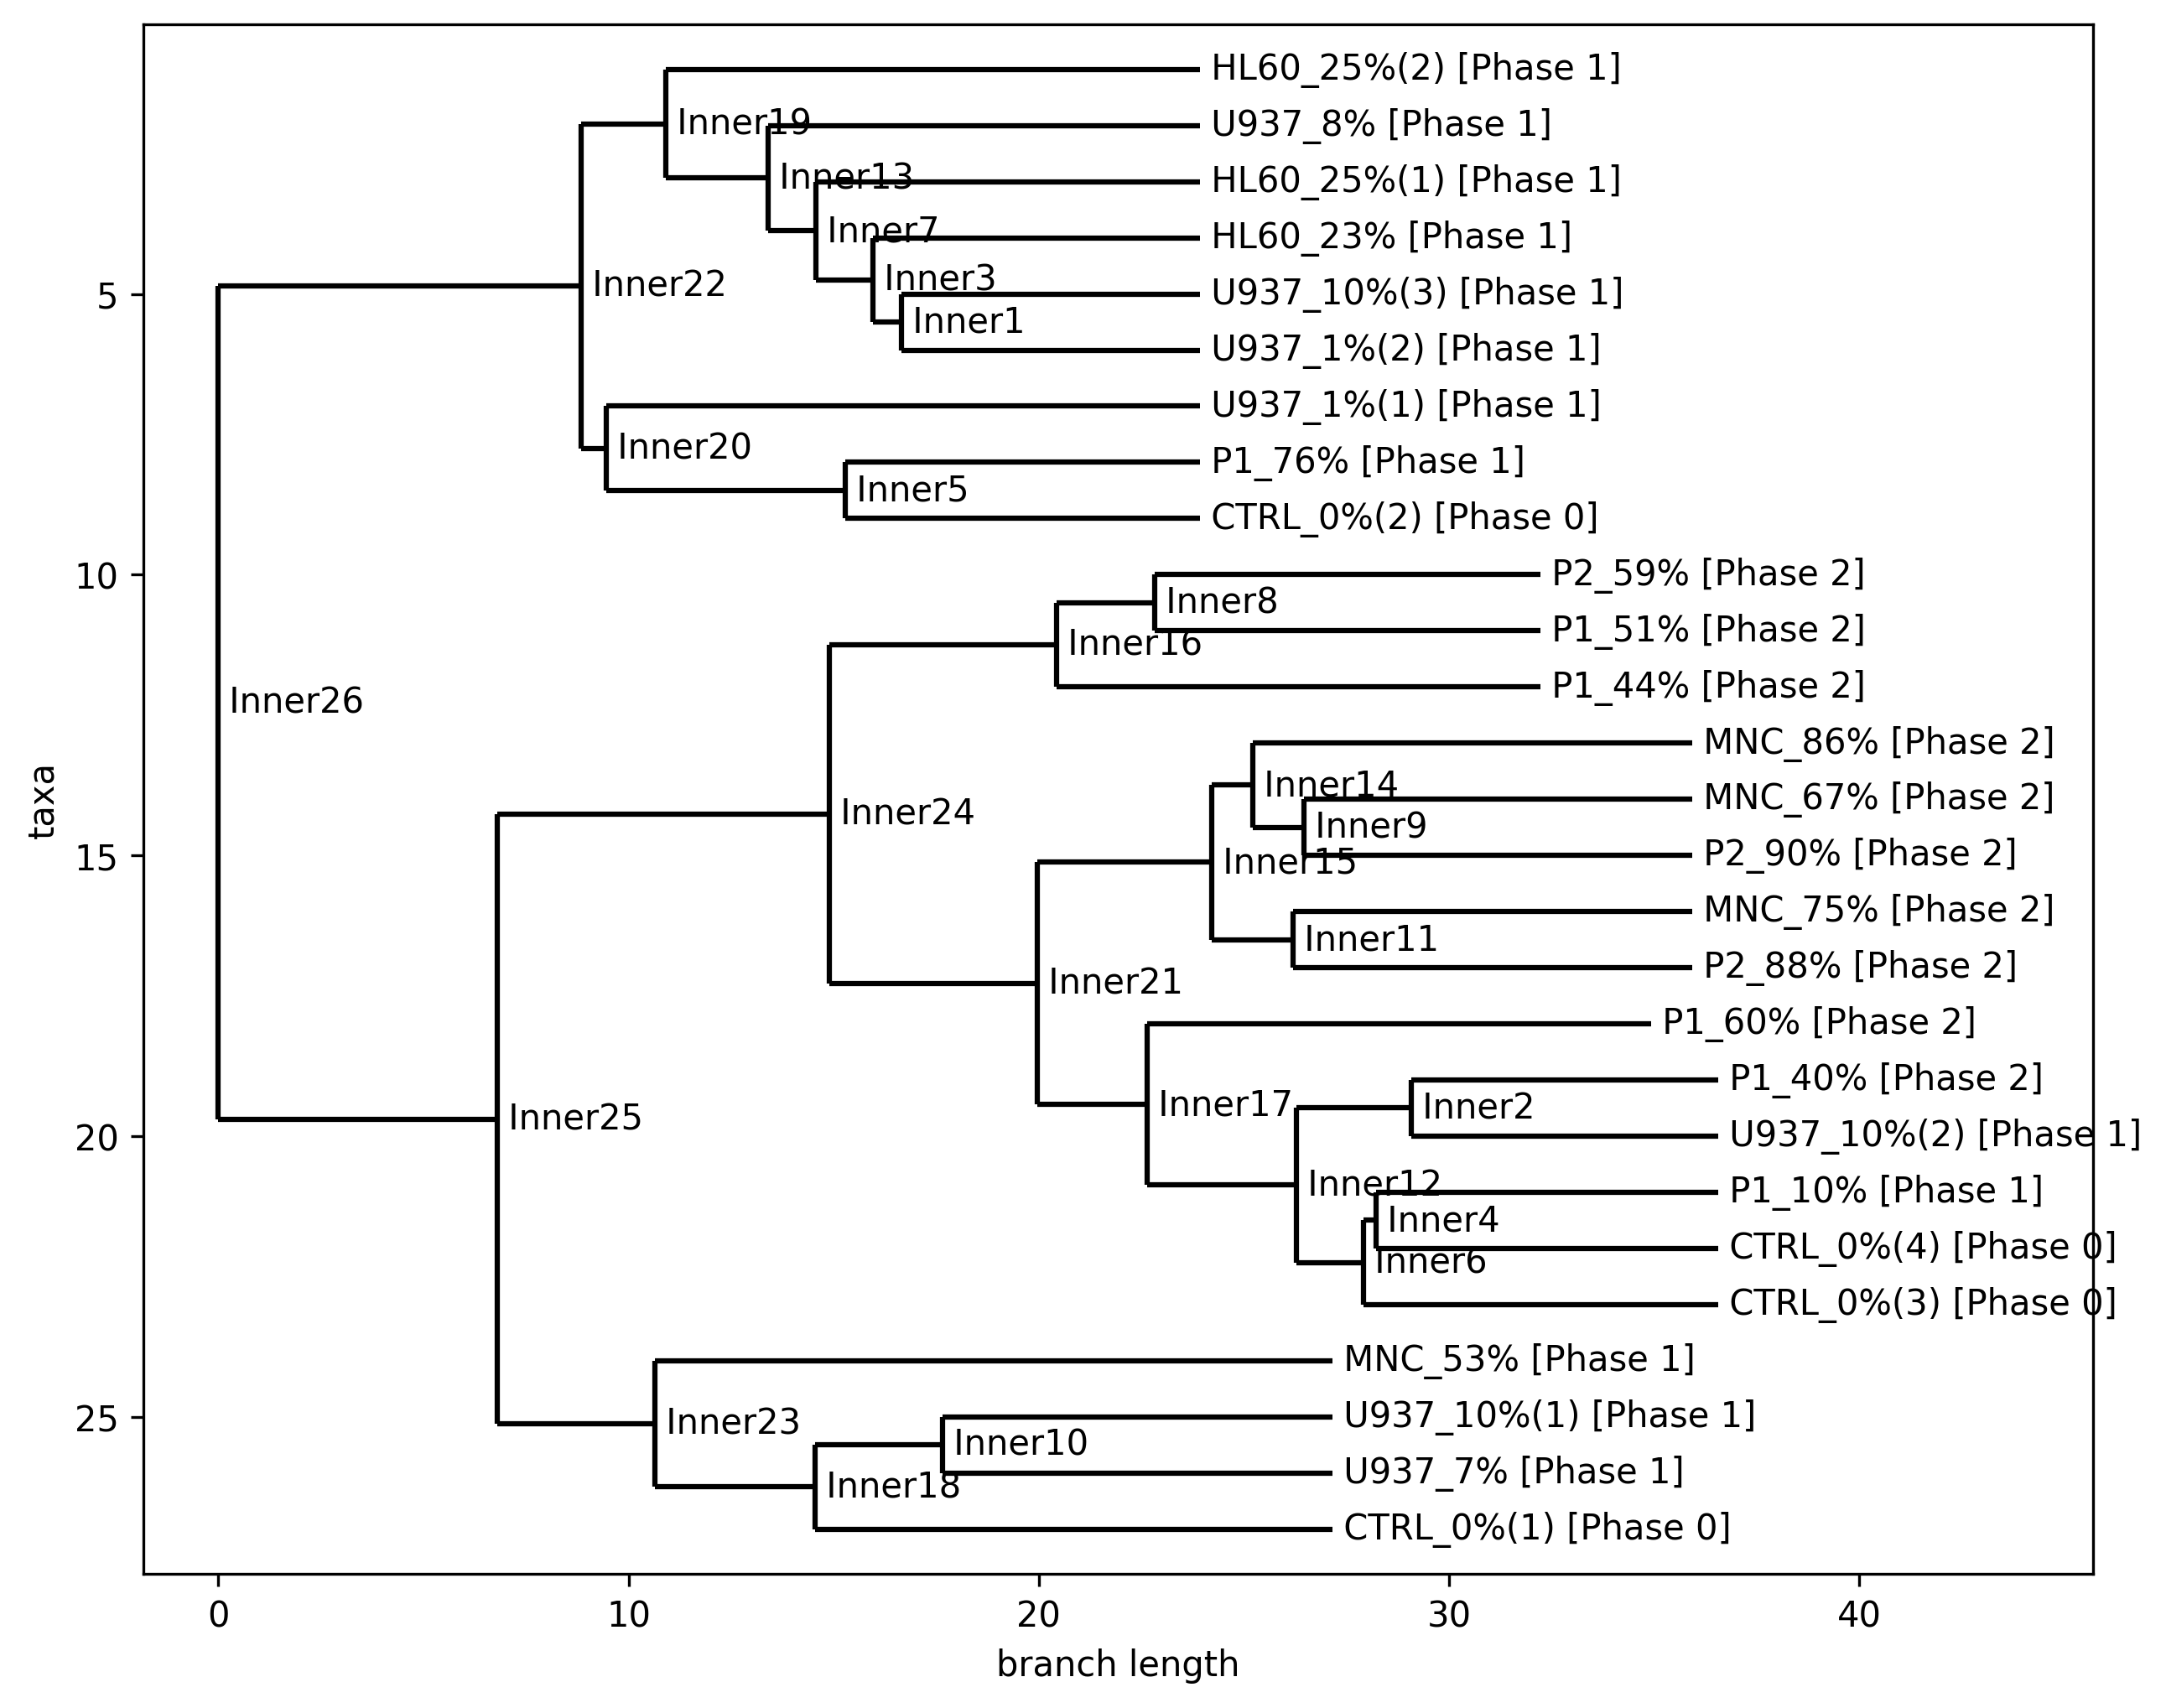

In [22]:
ph2_dist = []
for i in range(27):
    ls = []
    for j in range(i+1):
        ls.append(np.linalg.norm(ph2_pl100[i]-ph2_pl100[j]))
    ph2_dist.append(ls)
    
constructor = DistanceTreeConstructor()
ph2_distmat = Phylo.TreeConstruction._DistanceMatrix(name_phase, ph2_dist)
UPGMATree = constructor.upgma(ph2_distmat)
fig = plt.figure(figsize=(10,8), dpi=300)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(UPGMATree, axes=axes)

# Training and Testing of classifier

In [6]:
# take 50-50 split into training and test
ph0_train = []
ph0_test = []
ph1_train = []
ph1_test = []
ph2_train = []
ph2_test = []

for i in range(27):
    current_ph0 = pds_list[i][0]
    current_ph1 = pds_list[i][1]
    current_ph2 = pds_list[i][2]
    n0 = int(np.floor(current_ph0.shape[0]*0.5))
    n1 = int(np.floor(current_ph1.shape[0]*0.5))
    n2 = int(np.floor(current_ph2.shape[0]*0.5))
    np.random.shuffle(current_ph0)
    np.random.shuffle(current_ph1)
    np.random.shuffle(current_ph2)
    ph0_train.append(current_ph0[:n0,:])
    ph0_test.append(current_ph0[n0:,:])
    ph1_train.append(current_ph1[:n1,:])
    ph1_test.append(current_ph1[n1:,:])
    ph2_train.append(current_ph2[:n2,:])
    ph2_test.append(current_ph2[n2:,:])

# Outline Procedure
 1. Take 50 bootstrap samples from collated PH training set to train the classifier 
 2. Take 10 bootstrap sample from each sample in the test set as "new" dataset for testing
 (Classifiers can be trained on individual degree of homology or the 3 sets of landscapes concatenated or on the ph1 ne quadrant alone)
 
 

In [7]:
phase0_index = [0,1,2,3]
phase1_index = [4,5,6,7,8,9,10,11,12,13,14,19,23]
phase2_index = [15,16,17,18,20,21,22,24,25,26]

### PH0

ph0_phase0_train = [ph0_train[x] for x in phase0_index]
ph0_phase1_train = [ph0_train[x] for x in phase1_index]
ph0_phase2_train = [ph0_train[x] for x in phase2_index]

# stacking the training pts together
ph0_phase0_train_pts = np.vstack(ph0_phase0_train)
ph0_phase1_train_pts = np.vstack(ph0_phase1_train)
ph0_phase2_train_pts = np.vstack(ph0_phase2_train)

ph0_phase0_test = [ph0_test[x] for x in phase0_index]
ph0_phase1_test = [ph0_test[x] for x in phase1_index]
ph0_phase2_test = [ph0_test[x] for x in phase2_index]

# stacking the test pts together
ph0_phase0_test_pts = np.vstack(ph0_phase0_test)
ph0_phase1_test_pts = np.vstack(ph0_phase1_test)
ph0_phase2_test_pts = np.vstack(ph0_phase2_test)

############################################################################
### PH1

ph1_phase0_train = [ph1_train[x] for x in phase0_index]
ph1_phase1_train = [ph1_train[x] for x in phase1_index]
ph1_phase2_train = [ph1_train[x] for x in phase2_index]

# stacking the training pts together
ph1_phase0_train_pts = np.vstack(ph1_phase0_train)
ph1_phase1_train_pts = np.vstack(ph1_phase1_train)
ph1_phase2_train_pts = np.vstack(ph1_phase2_train)

ph1_phase0_test = [ph1_test[x] for x in phase0_index]
ph1_phase1_test = [ph1_test[x] for x in phase1_index]
ph1_phase2_test = [ph1_test[x] for x in phase2_index]

# stacking the test pts together
ph1_phase0_test_pts = np.vstack(ph1_phase0_test)
ph1_phase1_test_pts = np.vstack(ph1_phase1_test)
ph1_phase2_test_pts = np.vstack(ph1_phase2_test)


############################################################################
### PH2

ph2_phase0_train = [ph2_train[x] for x in phase0_index]
ph2_phase1_train = [ph2_train[x] for x in phase1_index]
ph2_phase2_train = [ph2_train[x] for x in phase2_index]

# stacking the training pts together
ph2_phase0_train_pts = np.vstack(ph2_phase0_train)
ph2_phase1_train_pts = np.vstack(ph2_phase1_train)
ph2_phase2_train_pts = np.vstack(ph2_phase2_train)

ph2_phase0_test = [ph2_test[x] for x in phase0_index]
ph2_phase1_test = [ph2_test[x] for x in phase1_index]
ph2_phase2_test = [ph2_test[x] for x in phase2_index]

# stacking the test pts together
ph2_phase0_test_pts = np.vstack(ph2_phase0_test)
ph2_phase1_test_pts = np.vstack(ph2_phase1_test)
ph2_phase2_test_pts = np.vstack(ph2_phase2_test)


#################################################################################
### PH1 NE
ph1ne_train = []
ph1ne_test = []
for i in range(27):
    x = ph1_train[i][:,0]
    y = ph1_train[i][:,1]
    ph1ne_train.append(ph1_train[i][(x>0)*(y>0),:])
    x1 = ph1_test[i][:,0]
    y1 = ph1_test[i][:,1]
    ph1ne_test.append(ph1_test[i][(x1>0)*(y1>0),:])

sub_phase0_train = [ph1ne_train[x] for x in phase0_index]
sub_phase1_train = [ph1ne_train[x] for x in phase1_index]
sub_phase2_train = [ph1ne_train[x] for x in phase2_index]

# stacking the training pts together
sub_phase0_train_pts = np.vstack(sub_phase0_train)
sub_phase1_train_pts = np.vstack(sub_phase1_train)
sub_phase2_train_pts = np.vstack(sub_phase2_train)

sub_phase0_test = [ph1ne_test[x] for x in phase0_index]
sub_phase1_test = [ph1ne_test[x] for x in phase1_index]
sub_phase2_test = [ph1ne_test[x] for x in phase2_index]

# stacking the test pts together
sub_phase0_test_pts = np.vstack(sub_phase0_test)
sub_phase1_test_pts = np.vstack(sub_phase1_test)
sub_phase2_test_pts = np.vstack(sub_phase2_test)


###########################################################################
### All degrees

all_phase0_train_pts = np.vstack([ph0_phase0_train, ph1_phase0_train, ph2_phase0_train])
all_phase1_train_pts = np.vstack([ph0_phase1_train, ph1_phase1_train, ph2_phase1_train])
all_phase2_train_pts = np.vstack([ph0_phase2_train, ph1_phase2_train, ph2_phase2_train])

all_phase0_test = [np.vstack([ph0_test[x], ph1_test[x], ph2_test[x]]) for x in phase0_index]
all_phase1_test = [np.vstack([ph0_test[x], ph1_test[x], ph2_test[x]]) for x in phase1_index]
all_phase2_test = [np.vstack([ph0_test[x], ph1_test[x], ph2_test[x]]) for x in phase2_index]

# stacking the test pts together
all_phase0_test_pts = np.vstack(all_phase0_test)
all_phase1_test_pts = np.vstack(all_phase1_test)
all_phase2_test_pts = np.vstack(all_phase2_test)


/rds/general/user/qw817/home/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


# Train KNN classifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Function that takes in train and test data, takes bootstrap samples transform into landscapes, then produces the accuracy of knn classifier
def bootstrap_knn_accuracy(train, test, dim):
    # input train is list of [ph0, ph1 and ph2] points
    # input test is list of lists of [[ph0], [ph1] and [ph2]] points
    
    n = 50 # take 50 bootstrap and compute landscapes
    y = np.array([0 for i in range(n)]+[1 for i in range(n)]+[2 for i in range(n)])
    
    pl_0 = PersistenceLandscaper(hom_deg=0, start = -15, stop = 0,  num_steps=100, flatten=True)
    pl_1 = PersistenceLandscaper(hom_deg=1, start = -10, stop = 10,  num_steps=100, flatten=True)
    pl_2 = PersistenceLandscaper(hom_deg=2, start = 0, stop = 20,  num_steps=100, flatten=True)
    landscapers = [pl_0, pl_1, pl_2]
    pl = landscapers[dim]
    
    train_samples = []
    test_samples = []
    
    for j in range(3):
        # train
        dataset = train[j]
        n = dataset.shape[0]
        # test
        dataset2 = test[j]v
        for i in range(50):
            inp = [[],[],[]]
            choice =  np.random.choice([k for k in range(n)], size =  int(np.floor(n/4)), replace=True)
            inp[dim] = dataset[choice,:]
            train_samples.append(pl.fit_transform(inp)[:8000])
        
        for l in dataset2:
            n3 = l.shape[0]
            for t in range(10):
                inp2 = [[],[],[]]
                choice2 =  np.random.choice([k for k in range(n3)], size =  int(np.floor(n3/2)), replace=True)
                inp2[dim] = l[choice2,:]
                test_samples.append(pl.fit_transform(inp2)[:8000])
            
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(np.array(train_samples), y)
    
    y_test = np.array([0 for i in range(len(test[0])*10)]+[1 for i in range(len(test[1])*10)]+[2 for i in range(len(test[2])*10)])
    perm = np.random.permutation(len(y_test)).tolist()

    X_test = np.array([test_samples[u] for u in perm])
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test[perm], y_pred)
    
    return accuracy
            


In [20]:
bootstrap_knn_accuracy([ph0_phase0_train_pts, ph0_phase1_train_pts, ph0_phase2_train_pts], [ph0_phase0_test, ph0_phase1_test, ph0_phase2_test],0)

0.14814814814814814

In [21]:
bootstrap_knn_accuracy([ph1_phase0_train_pts, ph1_phase1_train_pts, ph1_phase2_train_pts], [ph1_phase0_test, ph1_phase1_test, ph1_phase2_test],1)

0.14814814814814814

In [22]:
bootstrap_knn_accuracy([ph2_phase0_train_pts, ph2_phase1_train_pts, ph2_phase2_train_pts], [ph2_phase0_test, ph2_phase1_test, ph2_phase2_test],2)

0.14814814814814814

In [23]:
bootstrap_knn_accuracy([sub_phase0_train_pts, sub_phase1_train_pts, sub_phase2_train_pts], [sub_phase0_test, sub_phase1_test, sub_phase2_test],1)

0.14814814814814814

In [35]:
# if we take a smaller set of landscapes

def bootstrap_knn_accuracy_sm(train, test, dim):
    # input train is list of [ph0, ph1 and ph2] points
    # input test is list of lists of [[ph0], [ph1] and [ph2]] points
    
    n = 50 # take 50 bootstrap and compute landscapes
    y = np.array([0 for i in range(n)]+[1 for i in range(n)]+[2 for i in range(n)])
    
    pl_0 = PersistenceLandscaper(hom_deg=0, start = -15, stop = 0,  num_steps=100, flatten=True)
    pl_1 = PersistenceLandscaper(hom_deg=1, start = -10, stop = 10,  num_steps=100, flatten=True)
    pl_2 = PersistenceLandscaper(hom_deg=2, start = 0, stop = 20,  num_steps=100, flatten=True)
    landscapers = [pl_0, pl_1, pl_2]
    pl = landscapers[dim]
    
    train_samples = []
    test_samples = []
    
    for j in range(3):
        # train
        dataset = train[j]
        n = dataset.shape[0]
        # test
        dataset2 = test[j]
        for i in range(50):
            inp = [[],[],[]]
            choice =  np.random.choice([k for k in range(n)], size =  int(np.floor(n/4)), replace=True)
            inp[dim] = dataset[choice,:]
            train_samples.append(pl.fit_transform(inp)[:1000])
        
        for l in dataset2:
            n3 = l.shape[0]
            for t in range(10):
                inp2 = [[],[],[]]
                choice2 =  np.random.choice([k for k in range(n3)], size =  int(np.floor(n3/2)), replace=True)
                inp2[dim] = l[choice2,:]
                test_samples.append(pl.fit_transform(inp2)[:1000])
            
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(np.array(train_samples), y)
    
    y_test = np.array([0 for i in range(len(test[0])*10)]+[1 for i in range(len(test[1])*10)]+[2 for i in range(len(test[2])*10)])
    perm = np.random.permutation(len(y_test)).tolist()

    X_test = np.array([test_samples[u] for u in perm])
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test[perm], y_pred)
    
    return accuracy
            


In [37]:
print(bootstrap_knn_accuracy_sm([ph0_phase0_train_pts, ph0_phase1_train_pts, ph0_phase2_train_pts], [ph0_phase0_test, ph0_phase1_test, ph0_phase2_test],0))

print(bootstrap_knn_accuracy_sm([ph1_phase0_train_pts, ph1_phase1_train_pts, ph1_phase2_train_pts], [ph1_phase0_test, ph1_phase1_test, ph1_phase2_test],1))

print(bootstrap_knn_accuracy_sm([ph2_phase0_train_pts, ph2_phase1_train_pts, ph2_phase2_train_pts], [ph2_phase0_test, ph2_phase1_test, ph2_phase2_test],2))

print(bootstrap_knn_accuracy_sm([sub_phase0_train_pts, sub_phase1_train_pts, sub_phase2_train_pts], [sub_phase0_test, sub_phase1_test, sub_phase2_test],1))

0.14444444444444443
0.18518518518518517
0.1814814814814815
0.13703703703703704


# Train SVC and LinearSVC
For multi-class classification SVC miplements the "one-vs-one" resulting in 3 classifiers, whereas LinearSVC implements a “one-vs-rest” decision function of shape (n_samples, n_classes).


In [9]:
from sklearn import svm

# Function that takes in train and test data, takes bootstrap samples transform into landscapes, then produces the accuracy of svm classifier
def bootstrap_svc_accuracy(train, test, dim):
    # input train is list of [ph0, ph1 and ph2] points
    # input test is list of lists of [[ph0], [ph1] and [ph2]] points
    
    n = 50 # take 50 bootstrap and compute landscapes
    y = np.array([0 for i in range(n)]+[1 for i in range(n)]+[2 for i in range(n)])
    
    pl_0 = PersistenceLandscaper(hom_deg=0, start = -15, stop = 0,  num_steps=100, flatten=True)
    pl_1 = PersistenceLandscaper(hom_deg=1, start = -10, stop = 10,  num_steps=100, flatten=True)
    pl_2 = PersistenceLandscaper(hom_deg=2, start = 0, stop = 20,  num_steps=100, flatten=True)
    landscapers = [pl_0, pl_1, pl_2]
    pl = landscapers[dim]
    
    train_samples = []
    test_samples = []
    
    for j in range(3):
        # train
        dataset = train[j]
        n = dataset.shape[0]
        # test
        dataset2 = test[j]
        for i in range(50):
            inp = [[],[],[]]
            choice =  np.random.choice([k for k in range(n)], size =  int(np.floor(n/4)), replace=True)
            inp[dim] = dataset[choice,:]
            train_samples.append(pl.fit_transform(inp)[:8000])
        
        for l in dataset2:
            n3 = l.shape[0]
            for t in range(10):
                inp2 = [[],[],[]]
                choice2 =  np.random.choice([k for k in range(n3)], size =  int(np.floor(n3/2)), replace=True)
                inp2[dim] = l[choice2,:]
                test_samples.append(pl.fit_transform(inp2)[:8000])
            
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(np.array(train_samples), y)
    
    y_test = np.array([0 for i in range(len(test[0])*10)]+[1 for i in range(len(test[1])*10)]+[2 for i in range(len(test[2])*10)])
    perm = np.random.permutation(len(y_test)).tolist()

    X_test = np.array([test_samples[u] for u in perm])
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test[perm], y_pred)
    
    return accuracy
            


In [30]:
bootstrap_svc_accuracy([ph0_phase0_train_pts, ph0_phase1_train_pts, ph0_phase2_train_pts], [ph0_phase0_test, ph0_phase1_test, ph0_phase2_test],0)

0.14814814814814814

In [31]:
bootstrap_svc_accuracy([ph1_phase0_train_pts, ph1_phase1_train_pts, ph1_phase2_train_pts], [ph1_phase0_test, ph1_phase1_test, ph1_phase2_test],1)

0.17037037037037037

In [32]:
bootstrap_svc_accuracy([ph2_phase0_train_pts, ph2_phase1_train_pts, ph2_phase2_train_pts], [ph2_phase0_test, ph2_phase1_test, ph2_phase2_test],2)

0.15555555555555556

In [33]:
bootstrap_svc_accuracy([sub_phase0_train_pts, sub_phase1_train_pts, sub_phase2_train_pts], [sub_phase0_test, sub_phase1_test, sub_phase2_test],1)

0.14814814814814814

In [16]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Function that takes in train and test data, takes bootstrap samples transform into landscapes, then produces the accuracy of svm classifier
def bootstrap_linearsvc_accuracy(train, test, dim):
    # input train is list of [ph0, ph1 and ph2] points
    # input test is list of lists of [[ph0], [ph1] and [ph2]] points
    
    n = 50 # take 50 bootstrap and compute landscapes
    y = np.array([0 for i in range(n)]+[1 for i in range(n)]+[2 for i in range(n)])
    
    pl_0 = PersistenceLandscaper(hom_deg=0, start = -15, stop = 0,  num_steps=100, flatten=True)
    pl_1 = PersistenceLandscaper(hom_deg=1, start = -10, stop = 10,  num_steps=100, flatten=True)
    pl_2 = PersistenceLandscaper(hom_deg=2, start = 0, stop = 20,  num_steps=100, flatten=True)
    landscapers = [pl_0, pl_1, pl_2]
    pl = landscapers[dim]
    
    train_samples = []
    test_samples = []
    
    for j in range(3):
        # train
        dataset = train[j]
        n = dataset.shape[0]
        # test
        dataset2 = test[j]
        for i in range(50):
            inp = [[],[],[]]
            choice =  np.random.choice([k for k in range(n)], size =  int(np.floor(n/4)), replace=True)
            inp[dim] = dataset[choice,:]
            train_samples.append(pl.fit_transform(inp)[:8000])
        
        for l in dataset2:
            n3 = l.shape[0]
            for t in range(10):
                inp2 = [[],[],[]]
                choice2 =  np.random.choice([k for k in range(n3)], size =  int(np.floor(n3/2)), replace=True)
                inp2[dim] = l[choice2,:]
                test_samples.append(pl.fit_transform(inp2)[:8000])
            
    clf = make_pipeline(StandardScaler(), svm.LinearSVC(max_iter=10000)) 
    clf.fit(np.array(train_samples), y)
    
    y_test = np.array([0 for i in range(len(test[0])*10)]+[1 for i in range(len(test[1])*10)]+[2 for i in range(len(test[2])*10)])
    perm = np.random.permutation(len(y_test)).tolist()

    X_test = np.array([test_samples[u] for u in perm])
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test[perm], y_pred)
    
    return accuracy
            



In [17]:
print(bootstrap_linearsvc_accuracy([ph0_phase0_train_pts, ph0_phase1_train_pts, ph0_phase2_train_pts], [ph0_phase0_test, ph0_phase1_test, ph0_phase2_test],0))

print(bootstrap_linearsvc_accuracy([ph1_phase0_train_pts, ph1_phase1_train_pts, ph1_phase2_train_pts], [ph1_phase0_test, ph1_phase1_test, ph1_phase2_test],1))

print(bootstrap_linearsvc_accuracy([ph2_phase0_train_pts, ph2_phase1_train_pts, ph2_phase2_train_pts], [ph2_phase0_test, ph2_phase1_test, ph2_phase2_test],2))

print(bootstrap_linearsvc_accuracy([sub_phase0_train_pts, sub_phase1_train_pts, sub_phase2_train_pts], [sub_phase0_test, sub_phase1_test, sub_phase2_test],1))

0.14814814814814814
0.3851851851851852
0.18888888888888888
0.14814814814814814


In [18]:

# Function that takes in train and test data, takes bootstrap samples transform into landscapes, then produces the accuracy of svm classifier
def bootstrap_linearsvc_accuracy_sm(train, test, dim):
    # input train is list of [ph0, ph1 and ph2] points
    # input test is list of lists of [[ph0], [ph1] and [ph2]] points
    
    n = 50 # take 50 bootstrap and compute landscapes
    y = np.array([0 for i in range(n)]+[1 for i in range(n)]+[2 for i in range(n)])
    
    pl_0 = PersistenceLandscaper(hom_deg=0, start = -15, stop = 0,  num_steps=100, flatten=True)
    pl_1 = PersistenceLandscaper(hom_deg=1, start = -10, stop = 10,  num_steps=100, flatten=True)
    pl_2 = PersistenceLandscaper(hom_deg=2, start = 0, stop = 20,  num_steps=100, flatten=True)
    landscapers = [pl_0, pl_1, pl_2]
    pl = landscapers[dim]
    
    train_samples = []
    test_samples = []
    
    for j in range(3):
        # train
        dataset = train[j]
        n = dataset.shape[0]
        # test
        dataset2 = test[j]
        for i in range(50):
            inp = [[],[],[]]
            choice =  np.random.choice([k for k in range(n)], size =  int(np.floor(n/4)), replace=True)
            inp[dim] = dataset[choice,:]
            train_samples.append(pl.fit_transform(inp)[:500])
        
        for l in dataset2:
            n3 = l.shape[0]
            for t in range(10):
                inp2 = [[],[],[]]
                choice2 =  np.random.choice([k for k in range(n3)], size =  int(np.floor(n3/2)), replace=True)
                inp2[dim] = l[choice2,:]
                test_samples.append(pl.fit_transform(inp2)[:500])
            
    clf = make_pipeline(StandardScaler(), svm.LinearSVC(max_iter=5000))
    clf.fit(np.array(train_samples), y)
    
    y_test = np.array([0 for i in range(len(test[0])*10)]+[1 for i in range(len(test[1])*10)]+[2 for i in range(len(test[2])*10)])
    perm = np.random.permutation(len(y_test)).tolist()

    X_test = np.array([test_samples[u] for u in perm])
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test[perm], y_pred)
    
    return accuracy
            



In [19]:
print(bootstrap_linearsvc_accuracy_sm([ph0_phase0_train_pts, ph0_phase1_train_pts, ph0_phase2_train_pts], [ph0_phase0_test, ph0_phase1_test, ph0_phase2_test],0))

print(bootstrap_linearsvc_accuracy_sm([ph1_phase0_train_pts, ph1_phase1_train_pts, ph1_phase2_train_pts], [ph1_phase0_test, ph1_phase1_test, ph1_phase2_test],1))

print(bootstrap_linearsvc_accuracy_sm([ph2_phase0_train_pts, ph2_phase1_train_pts, ph2_phase2_train_pts], [ph2_phase0_test, ph2_phase1_test, ph2_phase2_test],2))

print(bootstrap_linearsvc_accuracy_sm([sub_phase0_train_pts, sub_phase1_train_pts, sub_phase2_train_pts], [sub_phase0_test, sub_phase1_test, sub_phase2_test],1))

0.15185185185185185
0.17407407407407408
0.3
0.1814814814814815
